In [15]:
import pandas as pd
import geopandas as gpd
import numpy as np
import censusdata
import matplotlib.pyplot as plt

# Import the data

Data comes from https://data.cityofchicago.org/ and have been added to folder as JSON files for sake of simplicity.

In [31]:
crime_df = pd.read_json("crimes.json")
housing_df = pd.read_json("housing.json")
tract_boundaries = gpd.read_file('b.geojson')
parks = gpd.read_file("park.geojson")

,x_coord,y_coord,objectid_1,facility_t,gisobjid,park,facility_n,park_no,geometry
0,-87.63769763,41.76299921,1,SPECIAL,2494.0,HAMILTON (ALEXANDER),CULTURAL CENTER,9.0,POINT (-87.63770 41.76300)
1,-87.63792903,41.76281652,2,INDOOR,2495.0,HAMILTON (ALEXANDER),GYMNASIUM,9.0,POINT (-87.63793 41.76282)
2,-87.6369136,41.76084939,3,OUTDOOR,2496.0,HAMILTON (ALEXANDER),BASEBALL JR/SOFTBALL,9.0,POINT (-87.63691 41.76085)
3,-87.63832013,41.76200536,4,OUTDOOR,2497.0,HAMILTON (ALEXANDER),BASEBALL JR/SOFTBALL,9.0,POINT (-87.63832 41.76201)
4,-87.63805917,41.76047385,5,OUTDOOR,2498.0,HAMILTON (ALEXANDER),BASEBALL JR/SOFTBALL,9.0,POINT (-87.63806 41.76047)


## Add census tract to the Crimes Dataset

crs is the coordinate system and EPSG:4326 is just earths longitude and latitude

gpd.sjoin() joins the data sets where each row in the first df is within the 'shape' of the second df

In [32]:
crime_gdf = gpd.GeoDataFrame(
    crime_df,
    crs="EPSG:4326",
    geometry=gpd.points_from_xy(crime_df.longitude, crime_df.latitude),
)
crime_gdf = gpd.sjoin(crime_gdf, tract_boundaries, how="left", predicate="within")

parks_gdf = gpd.GeoDataFrame(
    parks,
    crs="EPSG:4326",
    geometry=gpd.points_from_xy(parks.x_coord, parks.y_coord),
)
parks_gdf = gpd.sjoin(parks_gdf, tract_boundaries, how="left", predicate="within")

# Data Cleaning

In [54]:
housing_df["geoid"] = housing_df["geo_geoid"].astype(str)[:-4]
crime_gdf["geoid"] = crime_gdf["geoid10"]
parks_gdf["geoid"] = parks_gdf["geoid10"]

# print((crime_gdf['geoid10'].unique()))
# print((housing_df['geoid'].unique()))

# df = pd.DataFrame()
# df['geoid10'] = crime_gdf['geoid10'].unique()
# df["crime"] = crime_gdf.groupby("geoid10").size().values

# df["housing"] = housing_df.groupby("geoid").mean()
# # df['geoid'] = (crime_gdf["geoid10"].unique()+housing_df["geoid"].unique()).unique()
# # df['crime'] = crime_gdf.groupby('geoid10').size().values
crime_counts = crime_gdf["geoid"].value_counts().rename_axis("geoid").reset_index(name="crime_counts")
park_counts = parks_gdf["geoid"].value_counts().rename_axis("geoid").reset_index(name="park_counts")
# print(crime_gdf.groupby('geoid', as_index=False)['geoid'].count())
avg_house_sale = housing_df.groupby("geoid", as_index=False)["meta_sale_price"].mean()

df = pd.merge(avg_house_sale, crime_counts, on="geoid", how="left")
df = pd.merge(df, park_counts, on="geoid", how="left")
df.head()

,geoid,meta_sale_price,crime_counts,park_counts
0,17031010100,251400.301887,107.0,14.0
1,17031010201,232398.200000,87.0,17.0
2,17031010202,194247.500000,136.0,9.0
3,17031010300,225240.279720,93.0,6.0
4,17031010400,327220.535714,68.0,28.0


# Summary Statistics 

In [73]:
print("There are", df['meta_sale_price'].count(), "rows of data!")
cols = ['meta_sale_price', 'crime_counts', 'park_counts']

for x in cols:
    max_val = df[x].max()
    min_val = df[x].min()
    mean_val = df[x].mean()
    q3 = np.nanquantile(df[x], 0.75)
    median = np.nanquantile(df[x], 0.5)
    q1 = np.nanquantile(df[x], 0.25)
    print('The average', x, 'is', mean_val)
    print('The minimum', x, 'is', min_val)
    print('The 25th percentile value is', q1)
    print('The median percentile value is', median)
    print('The 75th percentile value is', q3)
    print('The maximum', x, 'is', max_val)
    print()

There are 793 rows of data!
The average meta_sale_price is 304099.0561288087
The minimum meta_sale_price is 32000.0
The 25th percentile value is 161937.16049382716
The median percentile value is 257090.36363636365
The 75th percentile value is 394079.6296296296
The maximum meta_sale_price is 1266841.7945205478

The average crime_counts is 61.95075757575758
The minimum crime_counts is 1.0
The 25th percentile value is 30.0
The median percentile value is 48.0
The 75th percentile value is 79.25
The maximum crime_counts is 640.0

The average park_counts is 10.229166666666666
The minimum park_counts is 1.0
The 25th percentile value is 2.0
The median percentile value is 7.0
The 75th percentile value is 15.0
The maximum park_counts is 71.0



# Visualizations of Data

Text(0, 0.5, 'Frequency')

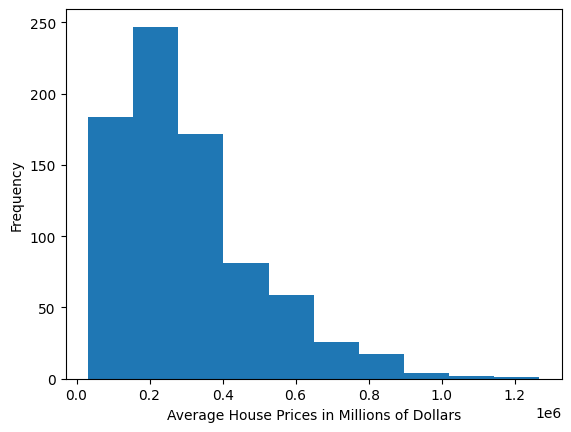

In [81]:
plt.hist(df['meta_sale_price'])
plt.xlabel("Average House Prices in Millions of Dollars")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

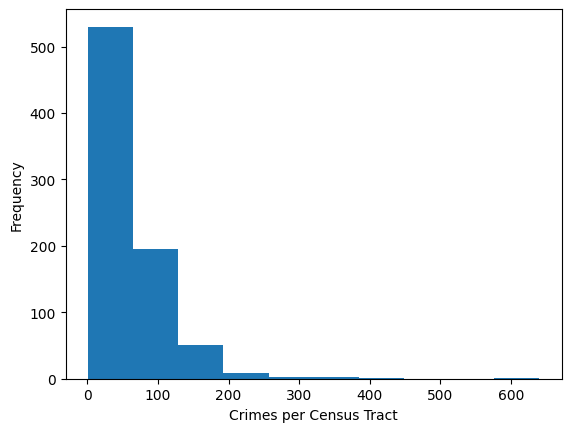

In [79]:
plt.hist(df['crime_counts'])
plt.xlabel("Crimes per Census Tract")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

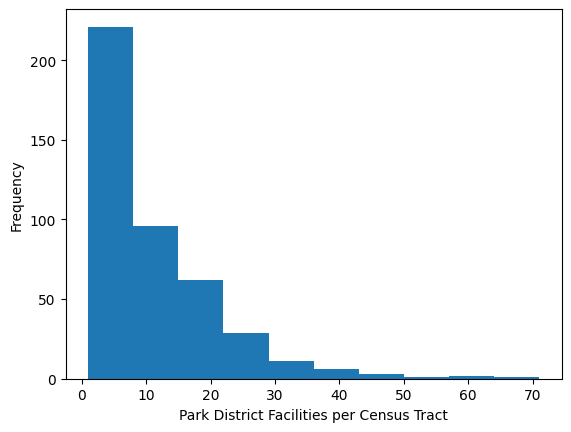

In [80]:
plt.hist(df['park_counts'])
plt.xlabel("Park District Facilities per Census Tract")
plt.ylabel("Frequency")

Plots showing the correlation between average sale price and crime then number of parks, respectively.

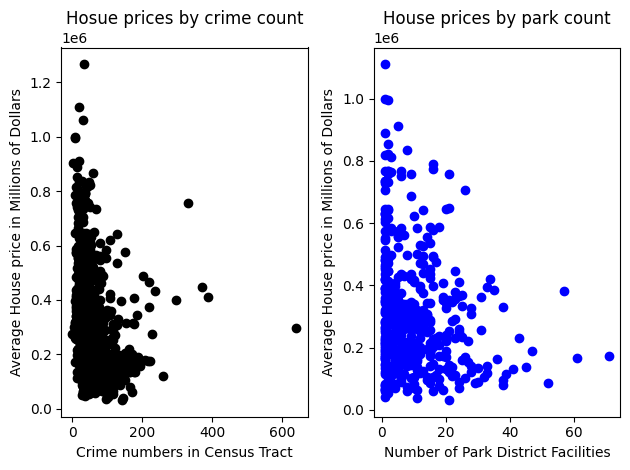

In [51]:

plt.subplot(1, 2, 1)
plt.plot(df['crime_counts'], df['meta_sale_price'], 'o', color='black')
plt.title('Hosue prices by crime count')
plt.xlabel('Crime numbers in Census Tract')
plt.ylabel('Average House price in Millions of Dollars')
plt.subplot(1, 2, 2)
plt.plot(df['park_counts'], df['meta_sale_price'], 'o', color='blue')
plt.title('House prices by park count')
plt.xlabel('Number of Park District Facilities')
plt.ylabel('Average House price in Millions of Dollars')
plt.tight_layout()
plt.show()

# Implementing Methods of Prediction

## Cross Validation with Linear Regression

In [177]:
import sklearn.linear_model as lm

In [178]:
train = df.sample(frac= 0.8, random_state= 491)
train = train.dropna()

test = pd.merge(df, train, on= ['geoid', 'meta_sale_price', 'crime_counts', 'park_counts'], how= 'left', indicator= True)
test = df[test['_merge'] == 'left_only']
test = test.dropna()
test.head()

,geoid,meta_sale_price,crime_counts,park_counts
1,17031010201,232398.200000,87.0,17.0
2,17031010202,194247.500000,136.0,9.0
5,17031010501,198932.738095,45.0,2.0
14,17031020302,251879.045977,31.0,12.0
16,17031020500,190110.068182,63.0,47.0


In [179]:
linmodel = lm.LinearRegression(fit_intercept= True).fit(X=train[['crime_counts', 'park_counts']] , y=train['meta_sale_price'])

In [180]:
predictions = linmodel.predict(test[['crime_counts', 'park_counts']])

total = 0
for i in range(len(predictions)):
    error = test['meta_sale_price'].iloc[i] - predictions[i]
    total += error**2
MSE = total/len(predictions)
MSE

28387067937.334415

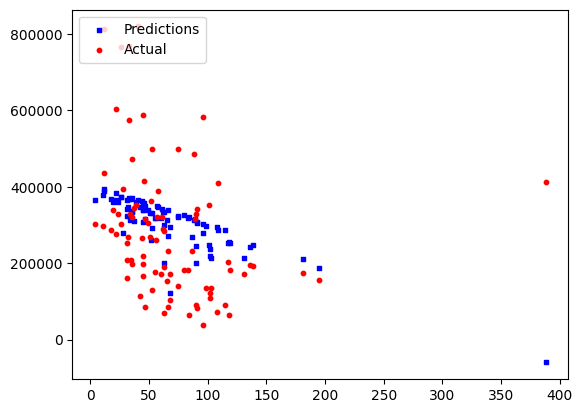

In [203]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
ax1.scatter(test[['crime_counts']], predictions, s=10, c='b', marker="s", label='Predictions')
ax1.scatter(test[['crime_counts']], test['meta_sale_price'], s=10, c='r', marker="o", label='Actual')
plt.legend(loc='upper left')
plt.show()

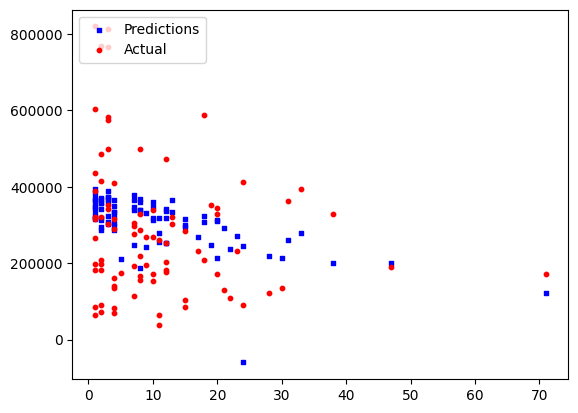

In [182]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
ax1.scatter(test[['park_counts']], predictions, s=10, c='b', marker="s", label='Predictions')
ax1.scatter(test[['park_counts']], test['meta_sale_price'], s=10, c='r', marker="o", label='Actual')
plt.legend(loc='upper left')
plt.show()

## Lasso Method Without Cross Validation for Alpha

Turns out exactly like normal linear regression

In [183]:
lasso_model = lm.Lasso(alpha=1.0, fit_intercept= True).fit(X=train[['crime_counts', 'park_counts']] , y=train['meta_sale_price'])

In [184]:
lasso_pred = lasso_model.predict(test[['crime_counts', 'park_counts']])

total = 0
for i in range(len(lasso_pred)):
    error = test['meta_sale_price'].iloc[i] - lasso_pred[i]
    total += error**2
lasso_MSE = total/len(lasso_pred)
lasso_MSE

28387066222.679073

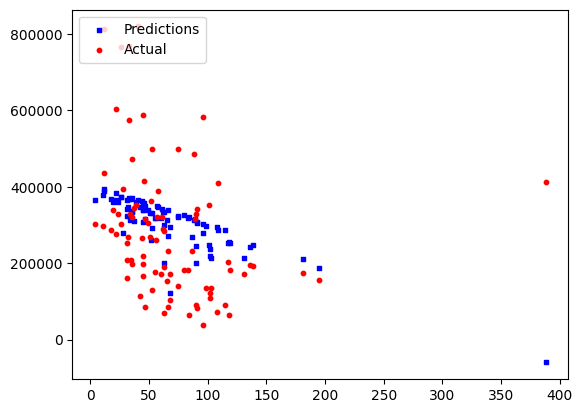

In [185]:
fig = plt.figure()
ax2 = fig.add_subplot(1, 1, 1)
ax2.scatter(test[['crime_counts']], lasso_pred, s=10, c='b', marker="s", label='Predictions')
ax2.scatter(test[['crime_counts']], test['meta_sale_price'], s=10, c='r', marker="o", label='Actual')
plt.legend(loc='upper left')
plt.show()

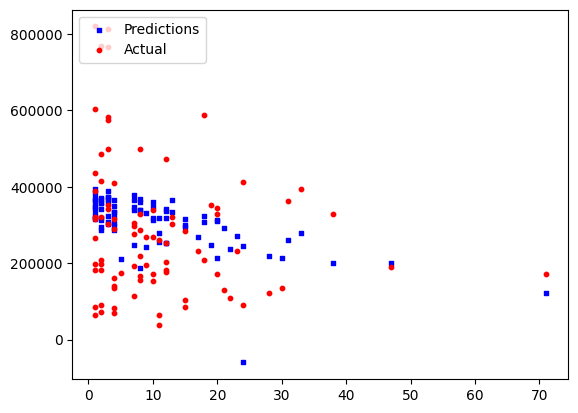

In [186]:
fig = plt.figure()
ax2 = fig.add_subplot(1, 1, 1)
ax2.scatter(test[['park_counts']], lasso_pred, s=10, c='b', marker="s", label='Predictions')
ax2.scatter(test[['park_counts']], test['meta_sale_price'], s=10, c='r', marker="o", label='Actual')
plt.legend(loc='upper left')
plt.show()

In [187]:
#import sklearn.model_selection

In [188]:
ridge_model = lm.RidgeCV(fit_intercept= True).fit(X=train[['crime_counts', 'park_counts']] , y=train['meta_sale_price'])

In [189]:
ridge_pred = ridge_model.predict(test[['crime_counts', 'park_counts']])

total = 0
for i in range(len(ridge_pred)):
    error = test['meta_sale_price'].iloc[i] - ridge_pred[i]
    total += error**2
ridge_MSE = total/len(ridge_pred)
ridge_MSE

28386890543.700768

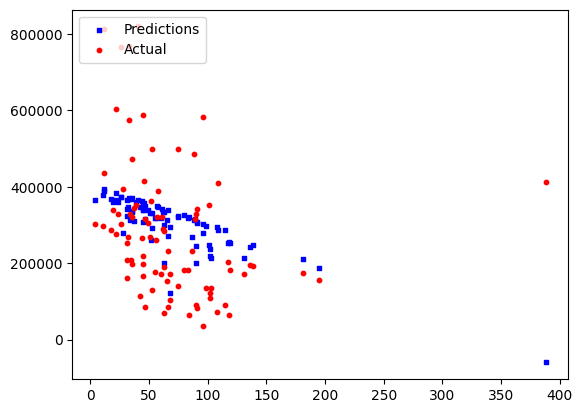

In [190]:
fig = plt.figure()
ax3 = fig.add_subplot(1, 1, 1)
ax3.scatter(test[['crime_counts']], ridge_pred, s=10, c='b', marker="s", label='Predictions')
ax3.scatter(test[['crime_counts']], test['meta_sale_price'], s=10, c='r', marker="o", label='Actual')
plt.legend(loc='upper left')
plt.show()

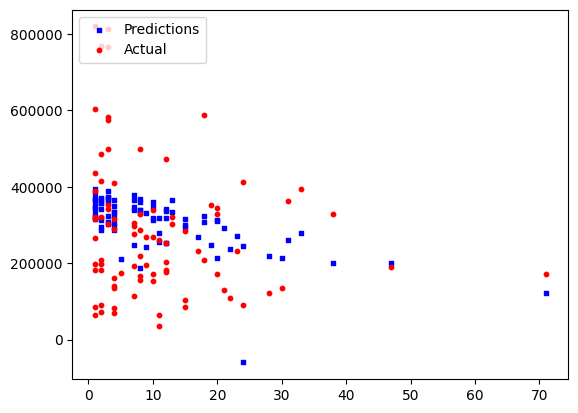

In [191]:
fig = plt.figure()
ax3 = fig.add_subplot(1, 1, 1)
ax3.scatter(test[['park_counts']], ridge_pred, s=10, c='b', marker="s", label='Predictions')
ax3.scatter(test[['park_counts']], test['meta_sale_price'], s=10, c='r', marker="o", label='Actual')
plt.legend(loc='upper left')
plt.show()

In [192]:
## CONSIDER CHECKING TRAINING MSE

# lin_train = linmodel.predict(train[['crime_counts', 'park_counts']])
# lasso_train = lasso_model.predict(train[['crime_counts', 'park_counts']])
# ridge_train = ridge_model.predict(train[['crime_counts', 'park_counts']])

# total = 0
# for i in range(len(ridge_pred)):
#     error = test['meta_sale_price'].iloc[i] - ridge_pred[i]
#     total += error**2
# ridge_MSE = total/len(ridge_pred)

np.argmin([MSE, lasso_MSE, ridge_MSE])

2

While the difference between the prediction models appear negligible, it is important to not that the y-values have a large spread. Small reductions in test MSE will not be apparent on the sctatterplots.